<a href="https://colab.research.google.com/github/kotech1/computervision/blob/master/11_gan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

실습 파일: `11-gan.ipynb`

# Autoencoder

In [22]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Conv2D, LeakyReLU, Flatten
from tensorflow.keras.layers import Dense, Conv2DTranspose
from tensorflow.keras.layers import Reshape, Activation
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import ModelCheckpoint

import os

#from utils.loaders import load_mnist
#from models.AE import Autoencoder

# run params
SAVE_FOLDER = 'data'

if not os.path.exists(SAVE_FOLDER):
    os.mkdir(SAVE_FOLDER)
    os.mkdir(os.path.join(SAVE_FOLDER, 'weights'))

In [23]:

MODE =  'build' #'load' #
#MODE =  'load'

In [24]:
z_dim = 2

encoder_input = keras.Input(shape=(28, 28, 1), name='encoder_input')
x = Conv2D(32, 3, strides=1, padding="same", name='encoder_conv_0')(encoder_input)
x = LeakyReLU()(x)
x = Conv2D(64, 3, strides=2, padding="same", name='encoder_conv_1')(x)
x = LeakyReLU()(x)
x = Conv2D(64, 3, strides=2, padding="same", name='encoder_conv_2')(x)
x = LeakyReLU()(x)
x = Conv2D(64, 3, strides=1, padding="same", name='encoder_conv_3')(x)
x = LeakyReLU()(x)
shape_before_flattening = K.int_shape(x)[1:]
x = Flatten()(x)
encoder_output= Dense(z_dim, name='encoder_output')(x)
encoder = keras.Model(encoder_input, encoder_output, name='encoder')

In [25]:
decoder_input = keras.Input(shape=(z_dim,), name='decoder_input')
x = Dense(np.prod(shape_before_flattening))(decoder_input)
x = Reshape(shape_before_flattening)(x)
x = layers.Conv2DTranspose(64, 3, strides=1, padding="same", name='decoder_conv_t0')(x)
x = LeakyReLU()(x)
x = layers.Conv2DTranspose(64, 3, strides=2, padding="same", name='decoder_conv_t1')(x)
x = LeakyReLU()(x)
x = layers.Conv2DTranspose(32, 3, strides=2, padding="same", name='decoder_conv_t2')(x)
x = LeakyReLU()(x)
x = layers.Conv2DTranspose(1, 3, strides=1, padding="same", name='decoder_conv_t3')(x)
decoder_output = Activation('sigmoid')(x)
decoder = keras.Model(decoder_input, decoder_output, name="decoder")

In [26]:
encoder.summary()
decoder.summary()

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   [(None, 28, 28, 1)]       0         
_________________________________________________________________
encoder_conv_0 (Conv2D)      (None, 28, 28, 32)        320       
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 28, 28, 32)        0         
_________________________________________________________________
encoder_conv_1 (Conv2D)      (None, 14, 14, 64)        18496     
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 14, 14, 64)        0         
_________________________________________________________________
encoder_conv_2 (Conv2D)      (None, 7, 7, 64)          36928     
_________________________________________________________________
leaky_re_lu_9 (LeakyReLU)    (None, 7, 7, 64)          0   

In [27]:
class AutoEncoder(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(AutoEncoder, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
    def call(self,inputs):
        latent = self.encoder(inputs)
        return self.decoder(latent)

@tf.function
def r_loss(y_true, y_pred):
    return K.mean(K.square(y_true - y_pred), axis = [1,2,3])

LEARNING_RATE = 0.0005
BATCH_SIZE = 32
INITIAL_EPOCH = 0
EPOCHS = 200

In [28]:
save_folder = os.path.join(SAVE_FOLDER, 'weights')

ae = AutoEncoder(encoder, decoder)
ae.compile(optimizer=keras.optimizers.Adam(lr=LEARNING_RATE), loss=r_loss)

if MODE == 'build':
    x = np.random.rand(1,28,28,1)
    ae.predict(x)
    ae.save(save_folder)
else:
    ae = keras.models.load_model(save_folder, custom_objects={'r_loss': r_loss})
    #ae.load_weights(save_folder+'/'+'checkpoint')

INFO:tensorflow:Assets written to: data/weights/assets


**학습하기**

In [37]:
# mnist 데이터 읽어오기
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
#mnist_digits = np.concatenate([x_train, x_test], axis=0)
#mnist_digits = np.expand_dims(mnist_digits, -1).astype("float32") / 255

x_train = x_train.reshape((60000, 28, 28, 1))
x_test = x_test.reshape((10000, 28, 28, 1))

x_train = x_train/255.
x_test = x_test/255.

# 매 epoch마다 모델 weights 저장
#lr_sched = step_decay_schedule(initial_lr=self.learning_rate, decay_factor=lr_decay, step_size=1)
checkpoint = ModelCheckpoint(save_folder+'/'+'checkpoint', save_weights_only = False, verbose=1)

#callbacks_list = [checkpoint]
callbacks_list = []
ae.fit(x_train[:1000], x_train[:1000], epochs=EPOCHS, batch_size=BATCH_SIZE, callbacks=callbacks_list)
ae.save(save_folder)

Epoch 1/200
32/32 [==============================] - 0s 5ms/step - loss: 0.0350
Epoch 2/200
32/32 [==============================] - 0s 5ms/step - loss: 0.0353
Epoch 3/200
32/32 [==============================] - 0s 5ms/step - loss: 0.0348
Epoch 4/200
32/32 [==============================] - 0s 5ms/step - loss: 0.0348
Epoch 5/200
32/32 [==============================] - 0s 5ms/step - loss: 0.0350
Epoch 6/200
32/32 [==============================] - 0s 5ms/step - loss: 0.0348
Epoch 7/200
32/32 [==============================] - 0s 5ms/step - loss: 0.0348
Epoch 8/200
32/32 [==============================] - 0s 5ms/step - loss: 0.0347
Epoch 9/200
32/32 [==============================] - 0s 5ms/step - loss: 0.0348
Epoch 10/200
32/32 [==============================] - 0s 5ms/step - loss: 0.0344
Epoch 11/200
32/32 [==============================] - 0s 5ms/step - loss: 0.0345
Epoch 12/200
32/32 [==============================] - 0s 5ms/step - loss: 0.0343
Epoch 13/200
32/32 [=================

**모델 읽어들이기**

In [38]:

save_folder = os.path.join(SAVE_FOLDER, 'weights')
#AE = AutoEncoder(encoder, decoder)
#AE.load_weights(save_folder+'/'+'checkpoint')
AE = keras.models.load_model(save_folder, custom_objects={'r_loss': r_loss})


**생성해 보기**

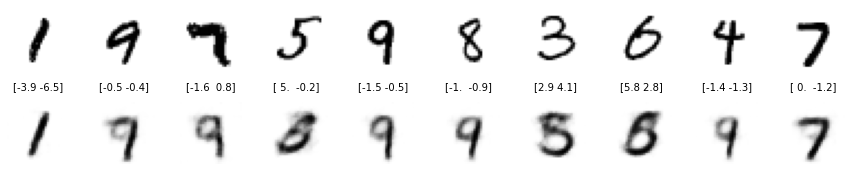

In [44]:
import matplotlib.pyplot as plt

n_to_show = 10
example_idx = np.random.choice(range(len(x_test)), n_to_show)
example_images = x_test[example_idx]

z_points = AE.encoder.predict(example_images)

reconst_images = ae.decoder.predict(z_points)

fig = plt.figure(figsize=(15, 3))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i in range(n_to_show):
    img = example_images[i].squeeze()
    ax = fig.add_subplot(2, n_to_show, i+1)
    ax.axis('off')
    ax.text(0.5, -0.35, str(np.round(z_points[i],1)), fontsize=10, ha='center', transform=ax.transAxes)   
    ax.imshow(img, cmap='gray_r')

for i in range(n_to_show):
    img = reconst_images[i].squeeze()
    ax = fig.add_subplot(2, n_to_show, i+n_to_show+1)
    ax.axis('off')
    ax.imshow(img, cmap='gray_r')


**Latent space의 분포**

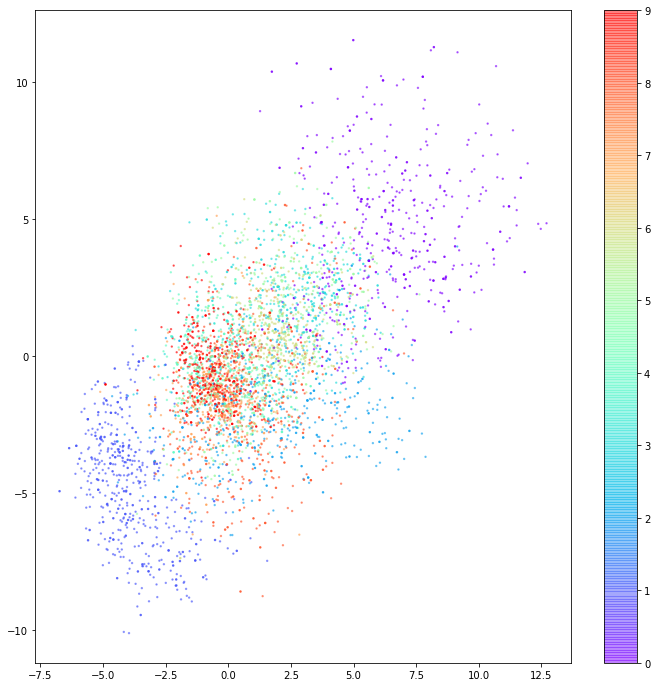

In [45]:
n_to_show = 5000
grid_size = 15
figsize = 12

example_idx = np.random.choice(range(len(x_test)), n_to_show)
example_images = x_test[example_idx]
example_labels = y_test[example_idx]

z_points = AE.encoder.predict(example_images)

plt.figure(figsize=(figsize, figsize))
plt.scatter(z_points[:, 0] , z_points[:, 1] , cmap='rainbow' , c= example_labels
            , alpha=0.5, s=2)
plt.colorbar()
plt.show()

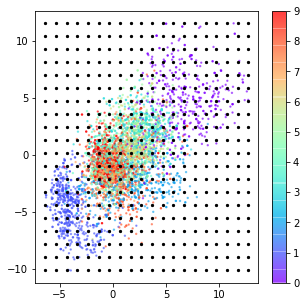

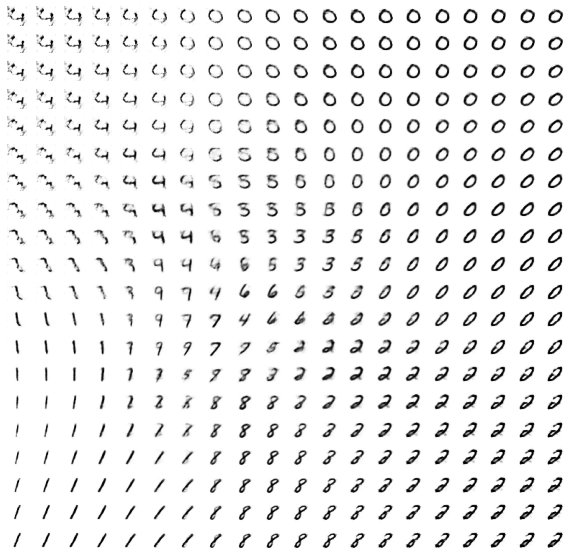

In [47]:
n_to_show = 5000
grid_size = 20
figsize = 10

example_idx = np.random.choice(range(len(x_test)), n_to_show)
example_images = x_test[example_idx]
example_labels = y_test[example_idx]

z_points = AE.encoder.predict(example_images)

plt.figure(figsize=(5, 5))
plt.scatter(z_points[:, 0] , z_points[:, 1] , cmap='rainbow' , c= example_labels
            , alpha=0.5, s=2)
plt.colorbar()

# x = norm.ppf(np.linspace(0.05, 0.95, 10))
# y = norm.ppf(np.linspace(0.05, 0.95, 10))
x = np.linspace(min(z_points[:, 0]), max(z_points[:, 0]), grid_size)
y = np.linspace(max(z_points[:, 1]), min(z_points[:, 1]), grid_size)
xv, yv = np.meshgrid(x, y)
xv = xv.flatten()
yv = yv.flatten()
z_grid = np.array(list(zip(xv, yv)))

reconst = AE.decoder.predict(z_grid)

plt.scatter(z_grid[:, 0] , z_grid[:, 1], c = 'black'#, cmap='rainbow' , c= example_labels
            , alpha=1, s=5)




plt.show()


fig = plt.figure(figsize=(figsize, figsize))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
for i in range(grid_size**2):
    ax = fig.add_subplot(grid_size, grid_size, i+1)
    ax.axis('off')
    ax.imshow(reconst[i, :,:,0], cmap = 'Greys')